In [1]:
import torch
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial

import glob
import numpy as np
import os
import subprocess

import torchvision.transforms as transforms

from PIL import Image, ImageFilter, ImageOps, ImageChops
import random
import numbers
import time
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm
#import pdb

__all__ = ['ResNeXt', 'resnet50', 'resnet101']


def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False)


def downsample_basic_block(x, planes, stride):
    out = F.avg_pool3d(x, kernel_size=1, stride=stride)
    zero_pads = torch.Tensor(
        out.size(0), planes - out.size(1), out.size(2), out.size(3),
        out.size(4)).zero_()
    if isinstance(out.data, torch.cuda.FloatTensor):
        zero_pads = zero_pads.cuda()

    out = Variable(torch.cat([out.data, zero_pads], dim=1))

    return out


class ResNeXtBottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, cardinality, stride=1,
                 downsample=None):
        super(ResNeXtBottleneck, self).__init__()
        mid_planes = cardinality * int(planes / 32)
        self.conv1 = nn.Conv3d(inplanes, mid_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(mid_planes)
        self.conv2 = nn.Conv3d(
            mid_planes,
            mid_planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            groups=cardinality,
            bias=False)
        self.bn2 = nn.BatchNorm3d(mid_planes)
        self.conv3 = nn.Conv3d(
            mid_planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNeXt(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 sample_size,
                 sample_duration,
                 shortcut_type='B',
                 cardinality=32,
                 num_classes=400,
                 input_channels=3,
                 output_layers=[]):
        self.inplanes = 64
        super(ResNeXt, self).__init__()
        self.conv1 = nn.Conv3d(
            input_channels,
            64,
            kernel_size=7,
            stride=(1, 2, 2),
            padding=(3, 3, 3),
            bias=False)
        
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1)
        self.layer1 = self._make_layer(block, 128, layers[0], shortcut_type,
                                       cardinality)
        self.layer2 = self._make_layer(
            block, 256, layers[1], shortcut_type, cardinality, stride=2)
        self.layer3 = self._make_layer(
            block, 512, layers[2], shortcut_type, cardinality, stride=2)
        self.layer4 = self._make_layer(
            block, 1024, layers[3], shortcut_type, cardinality, stride=2)
        last_duration = int(math.ceil(sample_duration / 16))
        last_size = int(math.ceil(sample_size / 32))
        self.avgpool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(cardinality * 32 * block.expansion, num_classes)
        
        #layer to output on forward pass
        self.output_layers = output_layers

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self,
                    block,
                    planes,
                    blocks,
                    shortcut_type,
                    cardinality,
                    stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(
                    downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride)
            else:
                downsample = nn.Sequential(
                    nn.Conv3d(
                        self.inplanes,
                        planes * block.expansion,
                        kernel_size=1,
                        stride=stride,
                        bias=False), nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(self.inplanes, planes, cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, cardinality))

        return nn.Sequential(*layers)

    def forward(self, x):
        #pdb.set_trace()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x5 = self.avgpool(x4)

        x6 = x5.view(x5.size(0), -1)
        x7 = self.fc(x6)
        
        if len(self.output_layers) == 0:
            return x7, x6
        else:
            out = []
            out.append(x7)
            for i in self.output_layers:
                if i == 'avgpool':
                    out.append(x6)
                if i == 'layer4':
                    out.append(x4)
                if i == 'layer3':
                    out.append(x3)

        return out

    def freeze_batch_norm(self):
        for name,m in self.named_modules():
            if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d): # PHIL: i Think we can write just  "if isinstance(m, nn._BatchNorm)
                m.eval() # use mean/variance from the training
                m.weight.requires_grad = False
                m.bias.requires_grad = False


def get_fine_tuning_parameters(model, ft_begin_index):
    if ft_begin_index == 0:
        return model.parameters()

    ft_module_names = []
    for i in range(ft_begin_index, 5):
        ft_module_names.append('layer{}'.format(i))
    ft_module_names.append('fc')

    print("Layers to finetune : ", ft_module_names)

    parameters = []
    for k, v in model.named_parameters():
        for ft_module in ft_module_names:
            if ft_module in k:
                parameters.append({'params': v})
                break
        else:
            parameters.append({'params': v, 'lr': 0.0})

    return parameters


def resnet50(**kwargs):
    """Constructs a ResNet-50 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 6, 3], **kwargs)
    return model


def resnet101(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 4, 23, 3], **kwargs)
    return model


def resnet152(**kwargs):
    """Constructs a ResNet-101 model.
    """
    model = ResNeXt(ResNeXtBottleneck, [3, 8, 36, 3], **kwargs)
    return model


In [2]:
def generate_model():
    model = resnet101(
            num_classes=400,
            shortcut_type='B',
            cardinality=32,
            sample_size=112,
            sample_duration=16,
            input_channels=3,
            output_layers=[])
    

    model = model.cuda()
    model = nn.DataParallel(model)

    return model

In [3]:
class Learner(nn.Module):
    def __init__(self, input_dim=2048, drop_p=0.0):
        super(Learner, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        self.drop_p = 0.6
        self.weight_init()
        self.vars = nn.ParameterList()

        for i, param in enumerate(self.classifier.parameters()):
            self.vars.append(param)

    def weight_init(self):
        for layer in self.classifier:
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight)

    def forward(self, x, vars=None):
        if vars is None:
            vars = self.vars
        x = F.linear(x, vars[0], vars[1])
        x = F.relu(x)
        x = F.dropout(x, self.drop_p, training=self.training)
        x = F.linear(x, vars[2], vars[3])
        x = F.dropout(x, self.drop_p, training=self.training)
        x = F.linear(x, vars[4], vars[5])
        return torch.sigmoid(x)

    def parameters(self):
        """
        override this function since initial parameters will return with a generator.
        :return:
        """
        return self.vars

## Change file_path to path of video you want to predict with demo

In [15]:
file_path = '/kaggle/input/crimeucfdataset/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Arrest/Arrest002_x264.mp4'

# Check if the directory exists in /kaggle/working/ and create it if not
save_directory = '/kaggle/working/' + os.path.basename(file_path)[:-4]
if not os.path.isdir(save_directory):
    os.mkdir(save_directory)

# Define the path for saving the images in the created directory
save_name = save_directory + '/%05d.jpg'

# Command to extract frames and save in the created directory
os.system('ffmpeg -i %s -r 25 -q:v 2 -vf scale=320:240 %s' % (file_path, save_name))

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

0

In [16]:
class ToTensor(object):
    def __init__(self, norm_value=255):
        self.norm_value = norm_value

    def __call__(self, pic):
    
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            # backward compatibility
            return img.float().div(self.norm_value)

        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        # put it from HWC to CHW format
        # yikes, this transpose takes 80% of the loading time/CPU
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(self.norm_value)
        else:
            return img

    def randomize_parameters(self):
        pass
        

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.sub_(m).div_(s)
        return tensor

    def randomize_parameters(self):
        pass

/tmp/ipykernel_47/1281256664.py:19: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --en

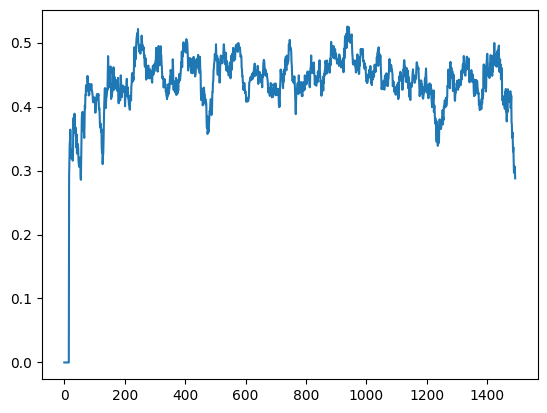

In [17]:
model = generate_model() # feature extrctir
classifier = Learner().cuda() # classifier
# classifier = nn.DataParallel(classifier)

checkpoint = torch.load('/kaggle/input/weight/RGB_Kinetics_16f.pth')
model.load_state_dict(checkpoint['state_dict'])
checkpoint = torch.load('/kaggle/input/testing/ckpt.pth')
classifier.load_state_dict(checkpoint['net'])

model.eval()
classifier.eval()

video = file_path.split('/')[-1][:-4]
path = '/kaggle/working/'+ video + '/*'
save_path = '/kaggle/working/'+ video +'_result'
img = glob.glob(path)
img.sort()

segment = len(img)//16
x_value =[i for i in range(segment)]

inputs = torch.Tensor(1, 3, 16, 240, 320)
x_time = [jj for jj in range(len(img))]
y_pred = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for num, i in enumerate(img):
    if num < 16:
        inputs[:,:,num,:,:] = ToTensor(1)(Image.open(i))
        cv_img = cv2.imread(i)
        # print(cv_img.shape)
        h,w,_ =cv_img.shape
        cv_img = cv2.putText(cv_img, 'FPS : 0.0, Pred : 0.0', (10,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (173, 216, 230), 2)
    else:
        inputs[:,:,:15,:,:] = inputs[:,:,1:,:,:]
        inputs[:,:,15,:,:] = ToTensor(1)(Image.open(i))
        inputs = inputs.cuda()
        start = time.time()
        output, feature = model(inputs)
        feature = F.normalize(feature, p=2, dim=1)
        #print(feature.shape)
        out = classifier(feature)
        y_pred.append(out.item())
        end = time.time()
        FPS = str(1/(end-start))[:5]
        out_str = str(out.item())[:5]
        #print(len(x_value)/len(y_pred))
                
        cv_img = cv2.imread(i)
        cv_img = cv2.putText(cv_img, 'FPS :'+FPS+' Pred :'+out_str, (10,15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (173, 216, 230), 2)
        if out.item() > 0.45:
            cv_img = cv2.rectangle(cv_img,(0,0),(w,h), (0,0,255), 3)

    if not os.path.isdir(save_path):
        os.mkdir(save_path)

    path = save_path+'/'+os.path.basename(i)
    cv2.imwrite(path, cv_img)

os.system('ffmpeg -i "%s" "%s"'%(save_path+'/%05d.jpg', save_path+'.mp4'))
plt.plot(x_time, y_pred)
plt.savefig(save_path+'.png', dpi=300)
#plt.cla()